# Imports

In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

# Dates and Other Constants

In [2]:
PATH = "./Stocks/"

# Start date defaults
S_YEAR = 2017
S_MONTH = 1
S_DAY = 3
S_DATE_STR = "2017-01-03"
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY)

# End date defaults
E_YEAR = 2021
E_MONTH = 8
E_DAY = 19
E_DATE_STR = "2021-08-19"
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY)

# Get Stock File Names in a List

In [3]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]

tickers.sort()
print(tickers)

['A', 'AA', 'AAL', 'AAME', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'ABBV', 'ABC', 'ABCB', 'ABEO', 'ABG', 'ABIO', 'ABM', 'ABMD', 'ABR', 'ABT', 'ABTX', 'AC', 'ACAD', 'ACBI', 'ACC', 'ACCO', 'ACER', 'ACGL', 'ACHC', 'ACHV', 'ACIW', 'ACLS', 'ACM', 'ACMR', 'ACN', 'ACNB', 'ACOR', 'ACRE', 'ACRS', 'ACRX', 'ACTG', 'ACU', 'ACY', 'ADBE', 'ADC', 'ADES', 'ADI', 'ADM', 'ADMA', 'ADMP', 'ADMS', 'ADNT', 'ADP', 'ADS', 'ADSK', 'ADTN', 'ADUS', 'ADVM', 'ADXS', 'AE', 'AEE', 'AEHR', 'AEIS', 'AEL', 'AEMD', 'AEO', 'AEP', 'AERI', 'AES', 'AEY', 'AFG', 'AFI', 'AFL', 'AGCO', 'AGEN', 'AGFS', 'AGIO', 'AGLE', 'AGM', 'AGNC', 'AGO', 'AGR', 'AGRX', 'AGTC', 'AGX', 'AGYS', 'AHH', 'AHT', 'AIG', 'AIMC', 'AIN', 'AINC', 'AIR', 'AIRG', 'AIRI', 'AIRT', 'AIT', 'AIV', 'AIZ', 'AJG', 'AJRD', 'AJX', 'AKAM', 'AKBA', 'AKR', 'AKTS', 'AL', 'ALB', 'ALBO', 'ALCO', 'ALDX', 'ALE', 'ALEX', 'ALG', 'ALGN', 'ALGT', 'ALJJ', 'ALK', 'ALKS', 'ALL', 'ALLE', 'ALLY', 'ALNA', 'ALNY', 'ALOT', 'ALPN', 'ALRM', 'ALSN', 'ALT', 'ALTR', 'ALV', 'ALX', 'ALX

# Function that Returns a Dataframe from a CSV

In [4]:
# Reads a dataframe from the CSV file, changes index to date and returns it
def get_df_from_csv(ticker):
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(PATH + ticker + '.csv')
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df
    
    print(PATH + ticker + '.csv')

# Function that Saves Dataframe to CSV

In [5]:
def save_dataframe_to_csv(df, ticker):
    df.to_csv(PATH + ticker + '.csv')

# Return 1st Valid Date in Dataframe

In [6]:
# Receives a start and end date and returns the 1st date in that range
def get_valid_dates(df, sdate, edate):
    try:
        mask = (df["Date"] > sdate) & (df["Date"] <= edate)
        sm_df = df.loc[mask]
        sm_df = sm_df.set_index(["Date"])
        
        # Get smallest date that matches
        sm_date = sm_df.index.min()
        last_date = sm_df.index.max()
        
        # Add leading zeros to date
        # Split string on - and if a number is less than 2 add a zero in front
        date_leading = '-'.join(('0' if len(x)<2 else '')+x for x in sm_date.split('-'))
        date_ending = '-'.join(('0' if len(x)<2 else '')+x for x in last_date.split('-'))
    except Exception:
        print("Date Corrupted")
    else:
        return date_leading, date_ending

# Returns Return on Investment over Time

In [7]:
def roi_between_dates(df, sdate, edate):
    try:
        start_val = df.loc[sdate, "Adj Close"]
        end_val = df.loc[edate, "Adj Close"]
        
        roi = ((end_val - start_val) / start_val)
    except Exception:
        print("Data Corrupted")
    else:
        return roi

# Get Mean Between Dates

In [8]:
def get_mean_between_dates(df, sdate, edate):
    mask = (df["Date"] > sdate) & (df["Date"] <= edate)
    
    return df.loc[mask]["Adj Close"].mean()

# Get Standard Deviation Between Dates

In [9]:
def get_std_between_dates(df, sdate, edate):
    mask = (df["Date"] > sdate) & (df["Date"] <= edate)
    
    return df.loc[mask]["Adj Close"].std()

# Get Coefficient of Variation Between Dates

In [10]:
def get_cov_between_dates(df, sdate, edate):
    mask = (df["Date"] > sdate) & (df["Date"] <= edate)
    
    mean = df.loc[mask]["Adj Close"].mean()
    std = df.loc[mask]["Adj Close"].std()
    
    cov = std / mean
    return cov

# Merge Multiple Stocks in One Dataframe by Column Name

In [11]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(x)
        df['Date'] = pd.to_datetime(df['Date'])
        # Use a mask to grab data between defined dates
        mask = (df['Date'] >= sdate) & (df['Date'] <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

# 11 Stock Market Sectors
<b>Technology</b> : Manufacturing of electronics, software, or related to information technology

<b>Health Care</b> : Biotech, hospitals, medical devices, drugs

<b>Financials</b> : Banks, investment funds, and insurance

<b>Real Estate</b> : Residential, industrial, and retail real estate

<b>Energy</b> : Production and supply of energy

<b>Materials</b> : Mining, refining, chemical, and forestry

<b>Consumer Discretionary</b> : Retailers, apparel, media, durables and services

<b>Industrials</b> : Construction, machinery, fabrication, manufacturing, defense, and aerospace

<b>Utilities</b> : Direct providers of electric, gas, and water

<b>Consumer Staples</b> : Food, beverage as well as products consumers deem essential

<b>Telecommunication</b> : Cable, internet providers, wireless, and satellite

# Get Sector Stocks

In [12]:
sec_df = pd.read_csv('./stock_sectors.csv')
sec_df

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care
...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet,Health Care
503,ZION,Zions Bancorp,Financials


In [13]:
# Get Industrials DF
indus_df = sec_df.loc[sec_df['Sector'] == "Industrials"]
health_df = sec_df.loc[sec_df['Sector'] == "Health Care"]
it_df = sec_df.loc[sec_df['Sector'] == "Information Technology"]
comm_df = sec_df.loc[sec_df['Sector'] == "Communication Services"]
staple_df = sec_df.loc[sec_df['Sector'] == "Consumer Staples"]
discretion_df = sec_df.loc[sec_df['Sector'] == "Consumer Discretionary"]
utility_df = sec_df.loc[sec_df['Sector'] == "Utilities"]
financial_df = sec_df.loc[sec_df['Sector'] == "Financials"]
material_df = sec_df.loc[sec_df['Sector'] == "Materials"]
restate_df = sec_df.loc[sec_df['Sector'] == "Real Estate"]
energy_df = sec_df.loc[sec_df['Sector'] == "Energy"]

# Returns a DF with ROIs for all Stock

In [14]:
def get_rois_for_stocks(stock_df):
    # Will hold all tickers & stock rois
    tickers = []
    rois = []
    
    # iterrows provides the index and column for each row in the DF
    for index, row in stock_df.iterrows():
        df = get_df_from_csv(row["Symbol"])
        
        # If we can't find the ticker delete it from the dataframe
        if df is None:
            pass
            # print(row['Symbol'], " is not available")
        else:
            tickers.append(row["Symbol"])
            sdate, edate = get_valid_dates(df, "2018-01-01", "2020-12-31")
            df = df.set_index(["Date"])
            roi = roi_between_dates(df, sdate, edate)
            rois.append(roi)
            
    return pd.DataFrame({"Ticker": tickers, "ROI": rois}) 

In [15]:
industrial = get_rois_for_stocks(indus_df)
health_care = get_rois_for_stocks(health_df)
it = get_rois_for_stocks(it_df)
commun = get_rois_for_stocks(comm_df)
staple = get_rois_for_stocks(staple_df)
discretion = get_rois_for_stocks(discretion_df)
utility = get_rois_for_stocks(utility_df)
finance = get_rois_for_stocks(financial_df)
material = get_rois_for_stocks(material_df)
restate = get_rois_for_stocks(restate_df)
energy = get_rois_for_stocks(energy_df)

File Doesn't Exist
./Stocks/OGN.csv


# Top Industrials

In [16]:
industrial.sort_values(by="ROI", ascending=False).head(5)

,Ticker,ROI
25,GNRC,3.734749
8,CARR,2.172381
11,CPRT,1.918578
64,TDG,1.518984
10,CTAS,1.325593


# Top Healthcare

In [17]:
health_care.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
25,DXCM,5.375582
44,MRNA,4.616667
33,IDXX,2.167543
61,WST,1.887307
50,RMD,1.575014


# Top Information Tech

In [18]:
it.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
21,ENPH,66.488464
2,AMD,7.352459
52,PAYC,4.622203
59,NOW,3.178471
72,ZBRA,2.705814


# Top Communications

In [19]:
commun.sort_values(by=['ROI'], ascending=False).head(20)

,Ticker,ROI
16,NFLX,1.689262
23,TWTR,1.209302
20,TMUS,1.105715
4,CHTR,0.895722
21,TTWO,0.840804
14,LYV,0.722861
22,DIS,0.666390
2,GOOG,0.644958
1,GOOGL,0.633082
10,FB,0.505677


# Top Staples

In [20]:
staple.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
11,EL,1.145196
10,COST,1.112863
20,MKC,0.977708
4,CHD,0.838448
26,PG,0.674050


# Top Discretionary

In [21]:
discretion.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
53,TSLA,10.007861
18,ETSY,7.541047
11,CMG,3.733606
44,POOL,1.931030
52,TGT,1.839621


# Top Utilities

In [22]:
utility.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
0,AES,1.402997
18,NEE,1.136332
4,AWK,0.819223
26,WEC,0.530405
27,XEL,0.519897


# Top Finance

In [23]:
finance.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
41,MSCI,2.612068
36,MKTX,1.860333
6,AJG,1.112315
39,MCO,1.044882
51,SPGI,1.012123


# Top Materials

In [24]:
material.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
4,BLL,1.474668
24,SHW,0.824243
16,LIN,0.785525
0,APD,0.771644
19,NEM,0.689577


# Top Real Estate

In [25]:
restate.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
22,SBAC,0.772695
8,EQIX,0.692928
18,PLD,0.689758
1,AMT,0.685782
5,CCI,0.622156


# Top Energy

In [26]:
energy.sort_values(by=['ROI'], ascending=False).head(5)

,Ticker,ROI
10,HES,0.168441
16,OKE,-0.131482
11,KMI,-0.146362
4,COP,-0.217487
21,WMB,-0.218709


# Portfolio List

In [27]:
port_list = ["GNRC", "DXCM", "AMD", "NFLX", "COST", 
             "TGT", "AES", "MSCI", "NEM", "SBAC", "HES"]

# Check for Correlation

In [28]:
mult_df = merge_df_by_column_name('daily_return',  '2018-01-01', '2020-12-31', *port_list)
mult_df

,GNRC,DXCM,AMD,NFLX,COST,TGT,AES,MSCI,NEM,SBAC,HES
251,-0.030089,0.010455,0.068093,0.047458,0.011820,0.036475,0.004617,0.009009,0.017057,-0.016711,0.008005
252,0.035395,0.001552,0.051913,0.019794,0.012001,-0.006802,-0.000919,0.015194,-0.008386,0.012513,0.032393
253,0.006837,-0.100379,0.049351,0.002829,-0.007766,-0.019652,-0.003680,0.015738,0.011099,-0.005472,0.024089
254,0.006790,0.019330,-0.019802,0.021203,-0.007139,0.010630,0.003694,0.010406,0.003659,0.006924,0.031034
255,-0.017457,0.040931,0.033670,0.009810,0.003888,0.009466,0.000000,0.001353,-0.001042,0.000123,0.006327
...,...,...,...,...,...,...,...,...,...,...,...
1002,0.027268,-0.002725,0.002840,-0.000991,0.007433,0.001601,-0.009366,0.008935,0.011710,0.007473,-0.012177
1003,-0.000686,0.020534,-0.002287,0.010020,0.017774,0.006850,0.001289,0.009041,-0.010913,0.004472,-0.013261
1004,-0.050077,-0.014932,-0.010699,0.022634,0.004474,-0.007654,0.000429,-0.004125,-0.001505,-0.000905,-0.004921
1005,0.035326,0.016447,0.018429,-0.011830,0.004642,-0.006627,-0.022737,0.005569,0.011050,-0.005218,0.022827


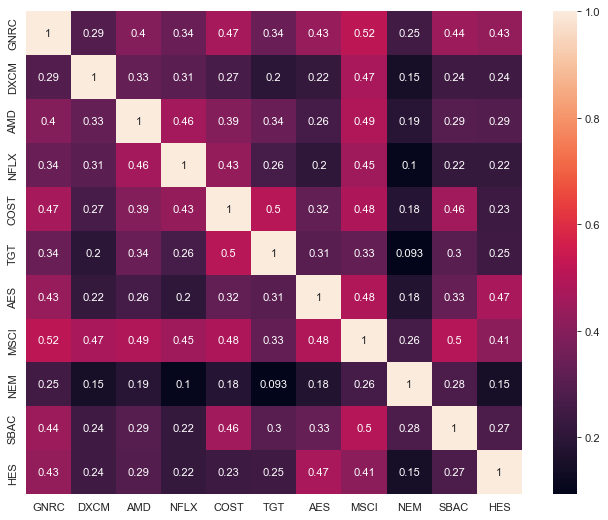

In [29]:
# Generate a Correlation Matrix
plt.figure(figsize=(10, 8), dpi=80)
sns.heatmap(mult_df.corr(), annot=True)
plt.show()

In [30]:
# Get the number of samples
days = len(mult_df.index)
days

756

In [31]:
def get_stock_price_on_date(ticker, date):
    df = get_df_from_csv(ticker)
    df = df.set_index(['Date'])
    return df.loc[date,'Adj Close']

In [32]:
# 01-04-2021 is the 1st date in 2021
print("GNRC $", get_stock_price_on_date('GNRC', '2021-01-04')) # 2 Shares at - 224.5599 $
print("DXCM $", get_stock_price_on_date('DXCM', '2021-01-04')) # 1 Shares at - 357.7399 $
print("AMD  $", get_stock_price_on_date('AMD', '2021-01-04'))  # 4 Shares at - 92.3000 $
print("NFLX $", get_stock_price_on_date('NFLX', '2021-01-04')) # 1 Shares at - 522.8599 $
print("COST $", get_stock_price_on_date('COST', '2021-01-04')) # 1 Shares at - 377.8815 $
print("TGT  $", get_stock_price_on_date('TGT', '2021-01-04'))  # 3 Shares at - 175.8225 $
print("AES  $", get_stock_price_on_date('AES', '2021-01-04'))  # 18 Shares at - 22.8200 $
print("MSCI $", get_stock_price_on_date('MSCI', '2021-01-04')) # 1 Shares at - 435.3967 $
print("NEM  $", get_stock_price_on_date('NEM', '2021-01-04'))  # 7 Shares at - 62.0733 $
print("SBAC $", get_stock_price_on_date('SBAC', '2021-01-04')) # 2 Shares at - 274.4242 $
print("HES  $", get_stock_price_on_date('HES', '2021-01-04'))  # 9 Shares at - 52.4686 $

GNRC $ 224.5599975585937
DXCM $ 357.739990234375
AMD  $ 92.3000030517578
NFLX $ 522.8599853515625
COST $ 377.8815307617188
TGT  $ 175.82254028320312
AES  $ 22.82006454467773
MSCI $ 435.3967590332031
NEM  $ 62.0733871459961
SBAC $ 274.4242248535156
HES  $ 52.46865844726562


In [33]:
port_list_share_count = {"GNRC":2, "DXCM":1, "AMD":4, "NFLX":1, "COST":1, 
             "TGT":3, "AES":18, "MSCI":1, "NEM":7, "SBAC":2, "HES":9}

def get_total_investment(port_list_share_count, date):
    tot_inv = 0

    for ticker in port_list_share_count.keys():
        
        df = get_df_from_csv(ticker)
        df = df.set_index(['Date'])
        
        tot_inv += df.loc[date,'Adj Close'] * port_list_share_count[ticker]
        
    return tot_inv

tot_inv = get_total_investment(port_list_share_count, '2021-01-04')
tot_inv

4906.007141113281

# Returns Portfolio Weight

In [34]:
def get_port_weight(price, total):
    return price / total

In [35]:
gnrc_w = get_port_weight(449.12, tot_inv)
dxcm_w = get_port_weight(357.74, tot_inv)
amd_w = get_port_weight(369.2, tot_inv)
nflx_w = get_port_weight(522.86, tot_inv)
cost_w = get_port_weight(377.88, tot_inv)
tgt_w = get_port_weight(527.46, tot_inv)
aes_w = get_port_weight(410.76, tot_inv)
msci_w = get_port_weight(435.40, tot_inv)
nem_w = get_port_weight(434.49, tot_inv)
sbac_w = get_port_weight(548.84, tot_inv)
hes_w = get_port_weight(472.23, tot_inv)

In [36]:
wts = np.array([gnrc_w, dxcm_w, amd_w, nflx_w, cost_w, tgt_w, aes_w, msci_w, \
                nem_w, sbac_w, hes_w])
wts

array([0.09154491, 0.07291877, 0.07525468, 0.10657547, 0.07702394,
       0.10751309, 0.08372593, 0.08874834, 0.08856286, 0.11187102,
       0.09625547])

In [37]:
port_var = np.dot(wts.T, np.dot(mult_df.cov() * 756, wts))
print("Portfolio Covariance :", port_var)
print("GNRC Var :", mult_df["GNRC"].var() * 756)
print("NFLX Var :", mult_df["NFLX"].var() * 756)

Portfolio Covariance : 0.18220831772632134
GNRC Var : 0.4394654360724252
NFLX Var : 0.5477253623043382


# Different Types of Risk

There is risk that you can limit through diversifaction (Idiosyncratic) and risk that you can't (Systematic). Systematic risk is caused by unforeseen conditions such as wars, recessions, natural disasters, dramatic changes in consumer actions, etc.

Data tells us that if we make a portfolio made up of approximately 25 stocks that aren't correlated that we can dramatically lower idiosyncratic risk. That is one reason why people invest in indexes. You can further lower risk by investing in other countries, bonds and cash.

# Diversifiable Risk

In [38]:
# Diversifiable Risk = Portfolio Variance - All Weighted Variances
def calc_diversifiable_risk(df, tickers, weights):
    # Gets number of days
    days = len(mult_df.index)
    # Calculate covariance of portfolio
    port_covar = np.dot(weights.T, np.dot(df.cov() * days, weights)) 
    
    i = 0
    while i < len(tickers):
        wt_sq = weights[i] ** 2
        stk_var = mult_df[tickers[i]].var() * days
        wt_var = wt_sq * stk_var
        port_covar = port_covar - wt_var
        i += 1
    return port_covar

In [39]:
div_risk = calc_diversifiable_risk(mult_df, port_list, wts)
print("Diversifiable Risk :", div_risk)

Diversifiable Risk : 0.13626503740806906


# Find Risk that Can't be Diversified

In [40]:
print("Systematic Risk :", (port_var - div_risk))

Systematic Risk : 0.04594328031825229
